In [ ]:
!pip install datasets

In [ ]:
!pip install faiss-cpu

In [1]:
from datasets import load_dataset, load_from_disk
from transformers import ViTImageProcessor,  ViTModel

In [ ]:
from PIL import Image, ImageOps
import io

import torch

import faiss

import numpy as np
import pandas as pd

from plotnine import *

%matplotlib inline
import matplotlib.offsetbox as offsetbox
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('agg')

from sklearn.manifold import TSNE

### Functions

In [3]:
def get_image(byte_string):
  image = Image.open(io.BytesIO(byte_string)).convert("L")
  image = Image.merge("RGB", (image, image, image))
  return image

In [4]:
def extract_features_batched(images, processor, model):
    inputs = processor(images=images, return_tensors="pt")
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings (features) from the last hidden state
    # We use the [CLS] token (first token) as the image representation
    features = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return features

def extract_features(images, processor, model):
    inputs = processor(images=images, return_tensors="pt")
    inputs = inputs.to(model.device)
    with torch.no_grad():
        outputs = model(**inputs)
    # Get the embeddings (features) from the last hidden state
    # We use the [CLS] token (first token) as the image representation
    features = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return features

### Data


In [ ]:
chartqa = load_dataset("ahmed-masry/ChartQA")

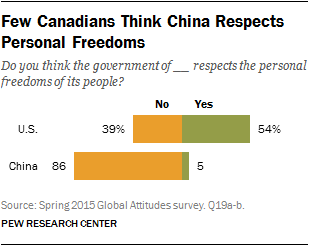

In [ ]:
get_image(chartqa["train"][3000]["image"])

### Generate Embeddings


##### Google ViT

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
model_identifier = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_identifier)
model = ViTModel.from_pretrained(model_identifier, device_map="auto")

In [ ]:
def get_embeddings(item):
  image = get_image(item["image"])
  item["embeddings"] = extract_features(image, processor, model)
  return item
embeddings = chartqa.map(get_embeddings, batched=False)

Map:   0%|          | 0/28299 [00:00<?, ? examples/s]

Map:   0%|          | 0/1920 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

In [ ]:
embeddings = embeddings.remove_columns(["imgname", "query", "label", "type"])

In [ ]:
embeddings.save_to_disk("/content/drive/MyDrive/AUB Research/VIP/Chart Frequency Analysis/chartqa_grayscale")

Saving the dataset (0/3 shards):   0%|          | 0/28299 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1920 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2500 [00:00<?, ? examples/s]

##### ResNet

### Load Embeddings

In [5]:
chartqa = load_from_disk("/content/drive/MyDrive/AUB Research/VIP/Chart Frequency Analysis/chartqa")

### Visualization

In [6]:
embeddings = np.array(chartqa["train"]["embeddings"])

In [ ]:
# Takes time
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

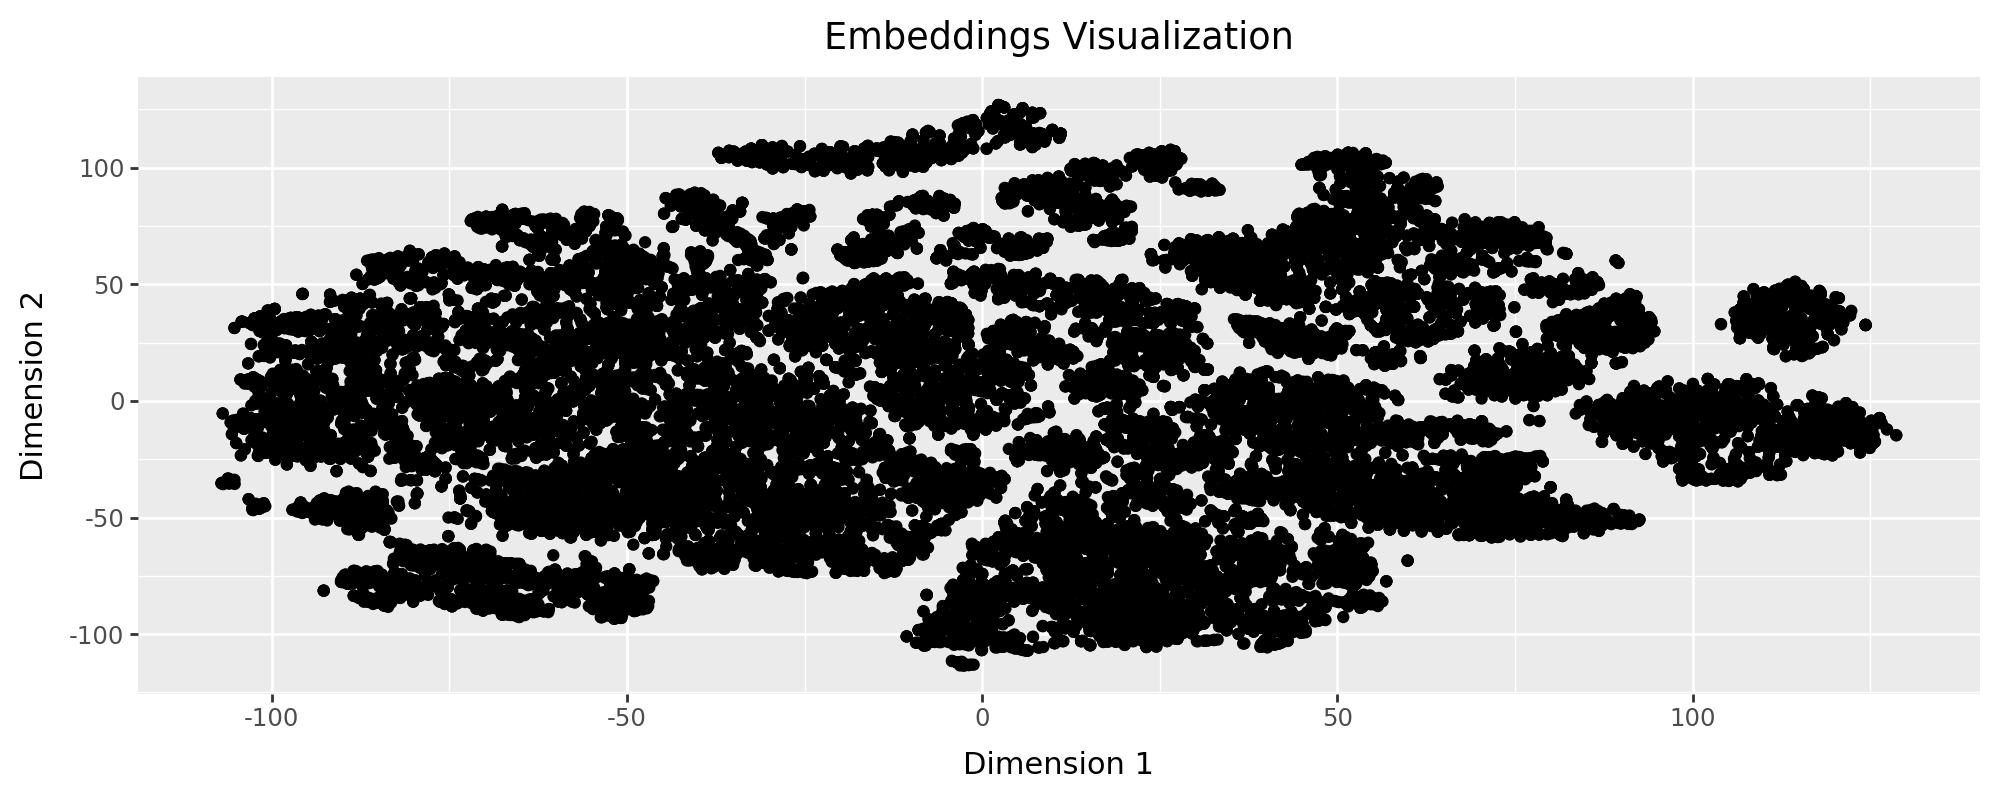

In [10]:
sample_indices = np.random.choice(len(embeddings_2d), size=28_000, replace=False)
sample = embeddings_2d[sample_indices]

df = pd.DataFrame({ "x": sample[:, 0], "y": sample[:, 1]})

plot = (
    ggplot(df, aes(x="x", y="y"))
    + geom_point()
    + labs(title="Embeddings Visualization", x="Dimension 1", y="Dimension 2")
    + theme(figure_size=(10, 4))
)
plot

In [11]:
sample_indices = np.random.choice(len(embeddings_2d), size=5_000, replace=False)
sample_embeddings = embeddings_2d[sample_indices]
sample_images = chartqa["train"].select(sample_indices)
sample_images = np.array(sample_images["image"])

In [12]:
df = pd.DataFrame({ "x": sample_embeddings[:, 0], "y": sample_embeddings[:, 1], "image": sample_images})

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(40, 40))
ax.scatter(df['x'], df['y'], color='blue', s=100)
for i, row in df.iterrows():
    img = get_image(row['image'])
    img_box = offsetbox.OffsetImage(img, zoom=0.05)
    img_box.set_offset((row['x'], row['y']))
    ab = offsetbox.AnnotationBbox(img_box, (row['x'], row['y']), frameon=False)
    ax.add_artist(ab)

ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_title('Google ViT Huge Embeddings of ChartQA Visualization (TSNE)')

plt.show()

### Find optimal k

In [ ]:
embeddings = np.array(chartqa["train"]["embeddings"])

In [ ]:
dim = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)

In [ ]:
k_values = range(5, 50)
intra_distances = []

for k in k_values:
    kmeans = faiss.Kmeans(dim, k)
    kmeans.train(embeddings)
    centroids = kmeans.centroids
    distances, labels = kmeans.index.search(embeddings, 1)
    sum_distance = np.sum(distances)
    intra_distances.append(sum_distance)

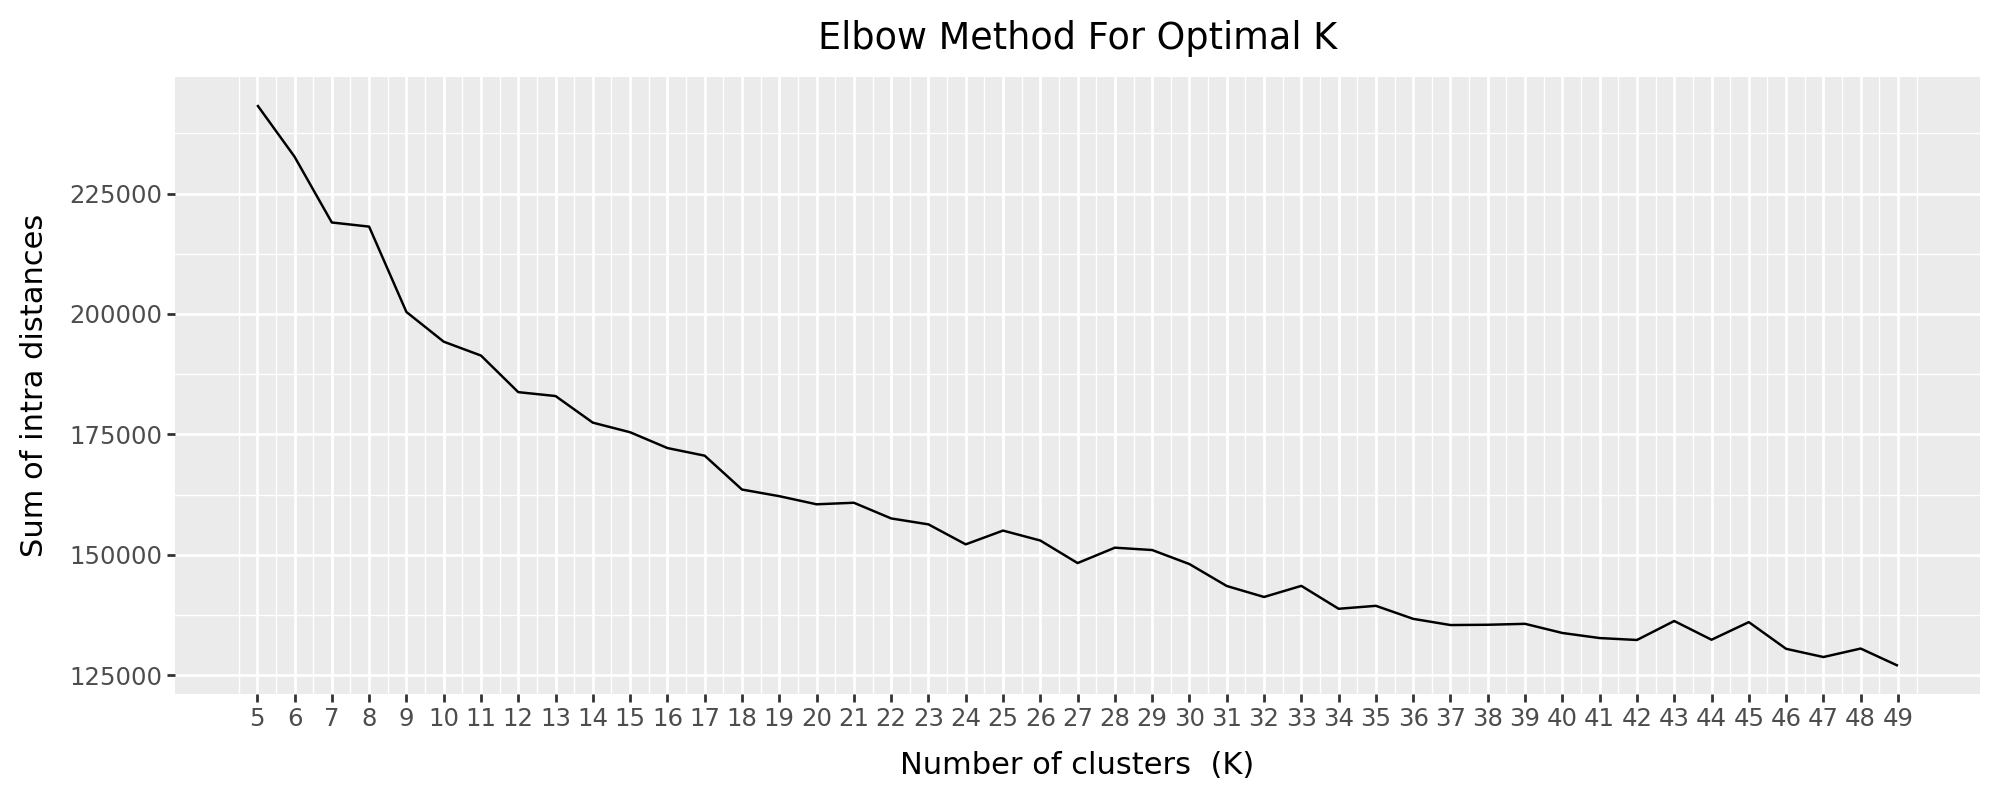

In [ ]:
df = pd.DataFrame({ "k": k_values, "intra_distances": intra_distances})

plot = (
    ggplot(df, aes(x="k", y="intra_distances"))
    + geom_line()
    + scale_x_continuous(breaks=range(5, 50))
    + labs(title="Elbow Method For Optimal K", x="Number of clusters  (K)", y="Sum of intra distances")
    + theme(figure_size=(10, 4))
)

plot